In [1]:
%%capture
# 更新或安装必要的库
!pip install --upgrade openai
!pip install --upgrade langchain
!pip install --upgrade python-dotenv
!pip install google-search-results
 

## ReAct with Agent

In [107]:
# 引入库
import openai
import os
from langchain.llms import OpenAI
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from dotenv import load_dotenv
load_dotenv()
 
# 载入 API keys; 如果没有，你需要先获取。 
os.environ["OPENAI_API_KEY"] = "OEPN_AI_API"
os.environ["SERPER_API_KEY"] = "aa8785a775f630cc3e542817a6e6d6757bb9fcea"

Quick start

https://www.promptingguide.ai/zh/techniques/react

现在我们可以配置 LLM，我们要用到的工具，以及允许我们将 ReAct 框架与 LLM 和其他工具结合使用的代理。请注意，我们使用搜索 API 来搜索外部信息，并使用 LLM 作为数学工具。

- load_tools:
https://github.com/hwchase17/langchain/blob/d9b5bcd691b1211e373a75ccfa88321bafc55382/langchain/agents/load_tools.py#L292

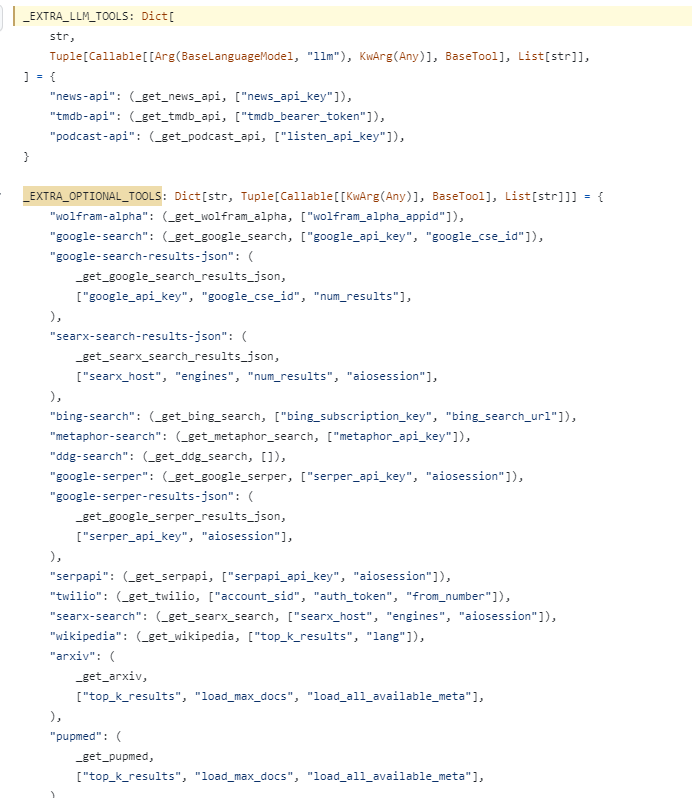

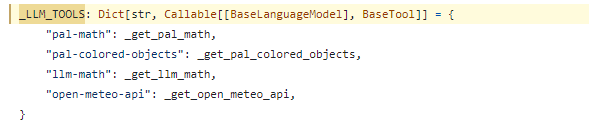

In [5]:
pip install wikipedia

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11707 sha256=477cfe51ee9f28b54947e5515b86c147092a2148a21964409e1df58f1fc9e6ce
  Stored in directory: c:\users\22100\appdata\local\pip\cache\wheels\c2\46\f4\caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.


### IBM

In [361]:
rxn_key = "apk-bd7e4a438dffd73eb9210c737a3c63c89e1532c88a64534b885ba64810dade3edad4a1163c9760d30fca191228be6ab86010e95bae9661db6d74cdff5897fc4f556d2968d041b0c92d9311a533773305"

In [370]:
from rxn4chemistry import RXN4ChemistryWrapper
rxn_predict = RXN4ChemistryWrapper(api_key=rxn_key, project_id='test')
rxn_predict.predict_reaction('BrBr.c1ccc2cc3ccccc3cc2c1')

{'response': {'payload': None,
  'metadata': {'uiMessages': {'errors': [{'code': None,
      'message': 'RESOURCE_NOT_FOUND',
      'type': 'ERROR',
      'description': None,
      'fieldId': None,
      'target': 'TOAST',
      'duration': 10000}],
    'infos': [],
    'warnings': []},
   'extendedPagination': {}}}}

### Agent initialize

#### Agent Type

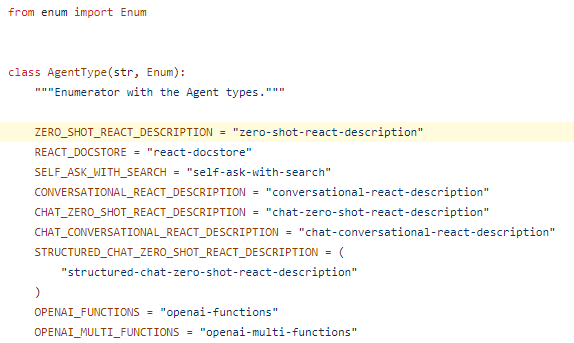
- zero-shot-react-description does not support multi-input tool 
- self-docstore does not support multi-input tool, 且工具数量==2

In [462]:
from langchain.tools import WikipediaQueryRun
from langchain.chat_models import ChatOpenAI

# llm = ChatOpenAI(temperature=0)
llm = OpenAI(model_name="text-davinci-003" ,temperature=0.2)

# tools = load_tools(["google-serper", "llm-math"], llm=llm)
# tools = load_tools(['wikipedia',"google-serper"], llm = llm)
# agent = initialize_agent(tools+ [check_no_extra_element_or_invalid]+ [get_molecule_properties] + [uspto_50k_dataset_search], llm, agent="zero-shot-react-description", 
#                          verbose=True, handle_parsing_errors=True)

tools = load_tools(['arxiv'], llm = llm)
agent = initialize_agent(tools+[check_no_extra_element_or_invalid]+ [get_molecule_properties] + [uspto_50k_dataset_search], llm, agent="zero-shot-react-description", 
                         verbose=True, handle_parsing_errors=True)

In [463]:
# 3个方面：性质、separate、机理
# question = """
# You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
# You can search for the properties of each reactants, separate reagents from reactants and reagents, and possible reaction mechanism of this reaction. \n 
# You should output the possible products in SMILES only.
# The input contains the reactants and reagents which are splitted by . 
# The product smiles must be valid and chemically reasonable. 
# Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
# Here are some examples: \n
# Reactants+Reagents: CC(C)(C)OC(=O)N1CCCC(N)CC1.O=C(Cl)OCc1ccccc1\n
# Products: CC(C)(C)OC(=O)N1CCCC(NC(=O)OCc2ccccc2)CC1\n
# Reactants+Reagents: CC(C)(C)OC(=O)N1CCC[C@@H]1CN.O=[N+]([O-])c1ccccc1F\n
# Products: CC(C)(C)OC(=O)N1CCC[C@@H]1CNc1ccccc1[N+](=O)[O-]\n
# Reactants+Reagents: COC(=O)[C@@H]1[C@@H](O)CCN1C(=O)OC(C)(C)C.O=C(O)c1ccccc1\n
# Products: COC(=O)[C@@H]1[C@H](OC(=O)c2ccccc2)CCN1C(=O)OC(C)(C)C\n
# Reactants+Reagents: CC(C)OC(=O)c1cc(N=C=S)ccc1Cl.CCOC(=O)[C@@H]1CCCN1\n
# Products: CCOC(=O)C1CCCN1C(=S)Nc1ccc(Cl)c(C(=O)OC(C)C)c1\n
# Reactants+Reagents: CC(C)NC[C@@H]1CN(C(=O)OC(C)(C)C)C[C@H]1C(C)(C)O[SiH2]C(C)(C)C.CCc1ccc(C(=O)O)cc1OCCCOC\n
# Products: CCc1ccc(C(=O)N(C[C@@H]2CN(C(=O)OC(C)(C)C)C[C@H]2C(C)(C)O[SiH2]C(C)(C)C)C(C)C)cc1OCCCOC\n
# Here is the question: \n
# Reactants+Reagents: CC(C)(C)OC(=O)NC1CCNCC1.O=C(NCCBr)OCc1ccccc1\n
# Products: \n
# """

############################################################################################################################################################################
# CC(C)(C)OC(=O)NC1CCN(CCNC(=O)OCc2ccccc2)CC1
# CCOC(=O)N1CCC[C@@H]1CNc1ccccc1[N+](=O)[O-]
# CC(C)(C)OC(=O)NC1CCNCC1 and O=C(NCCBr)OCc1ccccc1
question1 = """
You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. \n 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. \n
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
Due to different reaction conditions, there may be multiple possible products. You can output multiple products. \n

Here is the question: \n
Reactants+Reagents: CC(C)(C)OC(=O)N1CCCC(N)CC1.O=C(Cl)OCc1ccccc1\n
Products: \n
"""

# CN1CCC(c2c[nH]c3ccc(NC(=O)c4ccccc4)nc23)CC1
# CN1CCC(c2c[nH]c3ccc(NC(=O)c4ccccc4)cc23)CC1
question2 = """
You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. \n 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. \n
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable. 
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
Due to different reaction conditions, there may be multiple possible products. You can output multiple products. \n

Here is the question: \n
Reactants+Reagents: CN1CCC(c2c[nH]c3ccc(N)nc23)CC1.O=C(Cl)c1ccccc1\n
Products:
"""

# C[C@]1(C(=O)Nc2nccs2)Cc2cc(Oc3ccccc3)ccc2[C@H]1c1ccccc1
# CC[C@H](C)[C@@H](CN(C(=O)[C@@H]1C[C@H]1c1ccccn1)c1ccc(-c2ccc
# CC[C@]1(C(=O)Nc2nccs2)Cc2cc(-c3ccc(C(=O)[O-].[Cu+2].CCN(CC)CC)cc3)ccc2[C@H]1c1ccccc1
question3 = """
You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. \n 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. \n
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable. 
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
Due to different reaction conditions, there may be multiple possible products. You can output multiple products. \n
Here are some examples: \n
Reactants+Reagents: CC(C)Oc1ccc(B(O)O)cc1.CC[C@H](C)[C@@H](CN(C(=O)[C@@H]1C[C@H]1c1ccccn1)c1ccc(Br)cc1)NC(=O)OC(C)(C)C.O=P([O-])([O-])[O-].[K+].[K+].[K+].[Na+].[OH-]\n
Products: CC[C@H](C)[C@@H](CN(C(=O)[C@@H]1C[C@H]1c1ccccn1)c1ccc(-c2ccc(OC(C)C)cc2)cc1)NC(=O)OC(C)(C)C\n
Reactants+Reagents: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(Br)cc1)NC(=O)OC(C)(C)C.CN(C)c1ccc(B(O)O)cc1\n
Products: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(-c2ccc(N(C)C)cc2)cc1)NC(=O)OC(C)(C)C\n
Reactants+Reagents: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(Br)cc1)NC(=O)OC(C)(C)C.CN(C)C(=O)c1ccc(B(O)O)cc1\n
Products: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(-c2ccc(C(=O)N(C)C)cc2)cc1)NC(=O)OC(C)(C)C\n
Reactants+Reagents: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(Br)cc1)NC(=O)OC(C)(C)C.OB(O)c1ccccc1\n
Products: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(-c2ccccc2)cc1)NC(=O)OC(C)(C)C\n
Reactants+Reagents: CC(C)c1ccc(B(O)O)cc1.CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(Br)cc1)NC(=O)OC(C)(C)C\n
Products: CC[C@H](C)[C@@H](CN(C(=O)C1CC1c1ccccn1)c1ccc(-c2ccc(C(C)C)cc2)cc1)NC(=O)OC(C)(C)C\n
Here is the question: \n
Reactants+Reagents: C[C@]1(C(=O)Nc2nccs2)Cc2cc(O)ccc2[C@H]1c1ccccc1.OB(O)c1ccccc1.CC(=O)[O-].CC(=O)[O-].[Cu+2].CCN(CC)CC \n
Products:
"""

# CCCCN(CCCC)c1ccccc1
# CCCCNCCCCOC1CC1, CCCCNCCCCNC(=O)OCc1ccccc1, and CCCCNCCCCNC(=O)C1CC1
# COC1CC1
question4 = """
Now you are an expert chemist.
There is a test to see whether you can learn from the following examples, and predict the products of the question reactions. \n
Directly output the products in SMILES without any explanation. \n
Here are some examples: \n
Reactants+Reagents: CSc1ccc(O)cc1.F[B-](F)(F)C1CC1.[K+].O=O.CC(=O)[O-].CC(=O)[O-].[Cu+2].O=C([O-])[O-].[K+].[K+]\n
Products: CSc1ccc(OC2CC2)cc1\n
Reactants+Reagents: COc1ccc(B(O)O)cc1.CS(=N)(=O)C1CC1.CC(=O)[O-].CC(=O)[O-].[Cu+2]\n
Products: COc1ccc(N=S(C)(=O)C2CC2)cc1\n
Reactants+Reagents: F[B-](F)(F)C1CC1.Oc1ccc(Br)cc1.[K+].O=O.CC(=O)[O-].CC(=O)[O-].[Cu+2].O=C([O-])[O-].[K+].[K+]\n
Products: Brc1ccc(OC2CC2)cc1\n
Reactants+Reagents: Br[Mg]C1CC1.COC(=O)C(Cl)NC(=O)OCc1ccccc1\n
Products: COC(=O)C(NC(=O)OCc1ccccc1)C1CC1\n
Reactants+Reagents: Br[Mg]C1CC1.CC(C(=O)O)c1ccc(CBr)cc1\n
Products: CC(C(=O)O)c1ccc(CC2CC2)cc1\n
Here is the question: \n
Reactants+Reagents: Br[Mg]C1CC1.CC(C(=O)O)c1ccc(CBr)cc1\n
Products:
"""

# Cc1c(Cc2ccc(Cl)cc2)c(OC(F)F)nc2c(Cl)ccc(OC(C)(C)C(=O)O)c12
# COC(=O)C(C)(C)Oc1ccc(Cl)c2nc(OC(F)F)c(Cc3cccc(Cl)cc3)c(C)c12
question5 = """
You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
You can search for the properties of each reactants to help to predict the products. \n 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. \n
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable. 
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
Due to different reaction conditions, there may be multiple possible products. You can output multiple products. \n
Here are some examples: \n
Reactants+Reagents: Clc1nc2ccc(Br)cc2cc1Cc1ccccc1.c1c[nH]cn1\n
Products: Brc1ccc2nc(-n3ccnc3)c(Cc3ccccc3)cc2c1\n
Reactants+Reagents: CCOC(=O)CCNC(=O)c1ccc(C(CCC(F)(F)F)Nc2cnc3ccccc3c2)cc1\n
Products: O=C(O)CCNC(=O)c1ccc(C(CCC(F)(F)F)Nc2cnc3ccccc3c2)cc1\n
Reactants+Reagents: CN(C)CCS.Oc1ccc(-c2cc3ccccc3nc2Cl)cc1\n
Products: CN(C)CCSc1nc2ccccc2cc1-c1ccc(O)cc1\n
Reactants+Reagents: CCC(CC)(c1ccc(OCC(=O)C(C)(C)C)c(C)c1)c1ccc2cc(C(=O)Cl)ccc2c1.CNC\n
Products: CCC(CC)(c1ccc(OCC(=O)C(C)(C)C)c(C)c1)c1ccc2cc(C(=O)N(C)C)ccc2c1\n
Reactants+Reagents: CC(=O)/C=C/c1cc(F)c2ncc(C(=O)NCc3ccc(Cl)cc3)c(O)c2c1\n
Products: CC(=O)CCc1cc(F)c2ncc(C(=O)NCc3ccc(Cl)cc3)c(O)c2c1\n
Here is the question: \n
Reactants+Reagents: COC(=O)C(C)(C)Oc1ccc(Cl)c2nc(OC(F)F)c(Cc3ccc(Cl)cc3)c(C)c12\n
Products:
"""

############################################################################################################################################################################
question_zero_shot  = """
You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
You can search for the properties of each reactants to help to predict the products. \n 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. \n
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable. 
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
Due to different reaction conditions, there may be multiple possible products. You can output multiple products. \n
Reactants+Reagents: CC(C)(C)OC(=O)NC1CCNCC1.O=C(NCCBr)OCc1ccccc1\n
Reaction Type: \n
Products:
"""

agent.run(question4)



> Entering new AgentExecutor chain...
 I need to use the tools to answer this question.
Action: get_molecule_properties
Action Input: Br[Mg]C1CC1.CC(C(=O)O)c1ccc(CBr)cc1
Observation: Error: 'NoneType' object has no attribute 'text'
Thought: I need to separate the molecules.
Action: get_molecule_properties
Action Input: Br[Mg]C1CC1
Observation: Molecule with SMILES: Br[Mg]C1CC1
Molecular Weight: 145.28
Molecular Formula: C3H5BrMg
Number of H-Bond Donors: 0
Number of H-Bond Acceptors: 2
InChI Key: VFZXMEQGIIWBFJ-UHFFFAOYSA-M
InChI: InChI=1S/C3H5.BrH.Mg/c1-2-3-1;;/h1H,2-3H2;1H;/q-1;;+2/p-1

Thought: I need to get the properties of the other molecule.
Action: get_molecule_properties
Action Input: CC(C(=O)O)c1ccc(CBr)cc1
Observation: Molecule with SMILES: CC(C(=O)O)c1ccc(CBr)cc1
Molecular Weight: 243.10
Molecular Formula: C10H11BrO2
Number of H-Bond Donors: 1
Number of H-Bond Acceptors: 2
InChI Key: QQXBRVQJMKBAOZ-UHFFFAOYSA-N
InChI: InChI=1S/C10H11BrO2/c1-7(10(12)13)9-4-2-8(6-11)3-5-9/h2

'Agent stopped due to iteration limit or time limit.'

#### Evaluate Performance

In [435]:
# General_prompt = """
# You are an expert chemist. Please predict possible products of a reaction. 
# You may first search for the properties of each reactants, and search for similar reaction using tools, using these information to help predict the products to the question. 

# Then, Study these examples and use your own knowledge to predict the products of the question. 
# Finally, you should output the possible products in SMILES only with your own chemistry knowledge and previous analysis. There is no tool for you for the final prediction. 
# Before output the final result, you should evaluate whether this product is chemically reasonable, and does not contain other element out of reactants and reagents. 
# If the final result is not valid, you should repeat the process to predict the products.
# The input contains the reactants and reagents which are splitted by . 
# Due to different reaction conditions, there may be multiple possible products. You can output multiple products and explain your answer. \n
# """


# After get examples of similar reaction, you may need to use your own knowledge (do not try to find a tool) to generate possible reaction steps of these examples. 

General_prompt = """
You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. \n
You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. \n 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. \n
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. \n
Due to different reaction conditions, there may be multiple possible products. You can output multiple products. \n
"""



def get_prompt(target):
    prompt = General_prompt
    prompt += "Reactants+Reagents: " + target + "\n" +"Products:"
    return prompt

In [436]:
from tqdm import tqdm
def eval_agent(datadf):
    global agent
    result_list = []
    question_list = []
    answer_list = []

    datadf = datadf.sample(5).reset_index(drop=True)
    correct_count = 0
    for idx, row in tqdm(datadf.iterrows()):

        prompt = get_prompt(row["reactants_smiles"])
        print(prompt)
        
        question_list.append(row["reactants_smiles"])
        answer_list.append(row["products_smiles"])

        # --- run agent ---
        result = agent.run(prompt)
        result_list.append(result)

        if result == row["products_smiles"]:
            print("Correct!")
            correct_count += 1
    
    correct_rate = correct_count/len(datadf)
    print("Correct rate: ", correct_count/len(datadf))
    return result_list, question_list, answer_list, correct_rate



In [286]:
import pandas as pd
df_5reaction = pd.read_csv("data/5reaction.csv")

In [437]:
result_list, question_list, answer_list, correct_rate = eval_agent(uspto_50k_dataset)

0it [00:00, ?it/s]


You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. 

You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. 
 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. 

The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. 

Due to different reaction conditions, there may be multiple possible products. You can output multiple products. 

Reactants+Reagents: CC(C)(C)OC(=O)n1c(-c2ccc(Cl)c3c2C(=O)NC3)cc2cc(C=O)ccc21.NCc1ccccc1
Products:


> Entering new AgentExecutor chain...
 I can use uspto_50k_dataset_se

[01:21:59] SMILES Parse Error: syntax error while parsing: (
[01:21:59] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:21:59] SMILES Parse Error: syntax error while parsing: )
[01:21:59] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[01:21:59] SMILES Parse Error: syntax error while parsing: (
[01:21:59] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:21:59] SMILES Parse Error: syntax error while parsing: )
[01:21:59] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[01:21:59] SMILES Parse Error: syntax error while parsing: (
[01:21:59] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:21:59] SMILES Parse Error: syntax error while parsing: =
[01:21:59] SMILES Parse Error: Failed parsing SMILES '=' for input: '='
[01:21:59] SMILES Parse Error: syntax error while parsing: )
[01:21:59] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[01:21:59] non-ring atom 0 marked aromatic
[01:21:59] SMILES Parse Er

 I now know the final answer
Final Answer: CC(C)(C)OC(=O)n1c(-c2ccc(Cl)c3c2C(=O)NC3)cc2cc(CNCC3CCCCC3)ccc21

> Finished chain.

You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. 

You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. 
 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. 

The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. 

Due to different reaction conditions, there may be multiple possible products. You can output multiple products. 

Reactants+Reagents: CC(=O)O.CNC1CCN(C(=O)O

[01:22:23] SMILES Parse Error: syntax error while parsing: (
[01:22:23] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:22:23] SMILES Parse Error: syntax error while parsing: =
[01:22:23] SMILES Parse Error: Failed parsing SMILES '=' for input: '='
[01:22:23] SMILES Parse Error: syntax error while parsing: )
[01:22:23] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[01:22:23] SMILES Parse Error: syntax error while parsing: (
[01:22:23] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:22:23] SMILES Parse Error: syntax error while parsing: )
[01:22:23] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[01:22:23] SMILES Parse Error: syntax error while parsing: 1
[01:22:23] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[01:22:23] SMILES Parse Error: syntax error while parsing: (
[01:22:23] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:22:23] SMILES Parse Error: syntax error while parsing: (
[01:22:2

 The product of CC(=O)N(C)C1CCN(C(=O)OC(C)(C)C)CC1 is valid and chemically reasonable, so I will use it as my final answer.
Final Answer: CC(=O)N(C)C1CCN(C(=O)OC(C)(C)C)CC1

> Finished chain.
Correct!

You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. 

You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. 
 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. 

The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. 

Due to different reaction conditions, there may be multiple possible products. You 

[01:22:57] SMILES Parse Error: syntax error while parsing: (
[01:22:57] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:22:57] SMILES Parse Error: syntax error while parsing: =
[01:22:57] SMILES Parse Error: Failed parsing SMILES '=' for input: '='
[01:22:57] SMILES Parse Error: syntax error while parsing: )
[01:22:57] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[01:22:57] SMILES Parse Error: syntax error while parsing: [
[01:22:57] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[01:22:57] SMILES Parse Error: syntax error while parsing: @
[01:22:57] SMILES Parse Error: Failed parsing SMILES '@' for input: '@'
[01:22:57] SMILES Parse Error: syntax error while parsing: H
[01:22:57] SMILES Parse Error: Failed parsing SMILES 'H' for input: 'H'
[01:22:57] SMILES Parse Error: syntax error while parsing: ]
[01:22:57] SMILES Parse Error: Failed parsing SMILES ']' for input: ']'
[01:22:57] SMILES Parse Error: syntax error while parsing: 1
[01:22:5

 I now know the final answer
Final Answer: CCOCCOC(=O)N[C@H]1CCCC[C@@H]1n1cnc(C(=O)O)c1-c1ccccc1

> Finished chain.

You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. 

You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. 
 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. 

The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. 

Due to different reaction conditions, there may be multiple possible products. You can output multiple products. 

Reactants+Reagents: CCOc1ncnc2[nH]cc(Cc3ccc(Nc4ccc(Br

[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] SMILES Parse Error: syntax error while parsing: 1
[01:23:20] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] SMILES Parse Error: syntax error while parsing: 2
[01:23:20] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'
[01:23:20] SMILES Parse Error: syntax error while parsing: [
[01:23:20] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] SMILES Parse Error: syntax error while parsing: H
[01:23:20] SMILES Parse Error: Failed parsing SMILES 'H' for input: 'H'
[01:23:20] SMILES Parse Error: syntax error while parsing: ]
[01:23:20] SMILES Parse Error: Failed parsing SMILES ']' for input: ']'
[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] non-ring atom 0 marked aromatic
[01:23:20] SMILES Parse Error: syn

 I now know the final answer
Final Answer: CCOc1cc2[nH]ncc2cc1Nc1ncnc2[nH]c(CC)c(C)c12

> Finished chain.

You are an expert chemist. Please predict possible products of a reaction. Strictly follow the format. 

You can search for the similar reaction, and observe the change between products and reactants to help to predict the products. 
 
Then, you should output the possible products in SMILES only with your own knowledge. There is no tool for you for the final prediction. 

The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable.
Before output the final result, you should evaluate whether this product is chemically reasonable, not the same with reactants and reagents, and does not contain other element out of reactants and reagents. 

Due to different reaction conditions, there may be multiple possible products. You can output multiple products. 

Reactants+Reagents: COC(=O)c1cc(OC(C)=O)c2cc(C)oc2c1
Products:


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: Request failed due to server shutdown {
  "error": {
    "message": "Request failed due to server shutdown",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'Request failed due to server shutdown', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Fri, 21 Jul 2023 17:23:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '141', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'text-davinci-003', 'openai-organization': 'notre-dame-2', 'openai-processing-ms': '549', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '3000', 'x-ratelimit-limit-tokens': '250000', 'x-ratelimit-remaining-requests': '2999', 'x-ratelimit-remaining-tokens': '249744', 'x-ratelimit-reset-requests': '20ms', 'x-ra

 I can observe the change between reactants and products, and use my knowledge to generate possible products.
Action: Generate possible products with my own knowledge
Action Input: Knowledge of organic chemistry
Observation: Generate possible products with my own knowledge is not a valid tool, try another one.
Thought: I can use check_no_extra_element_or_invalid tool to check whether the products are valid and do not contain other element out of reactants and reagents.
Action: check_no_extra_element_or_invalid
Action Input: COC(=O)c1cc(OC(C)=O)c2cc(C)oc2c1.CC(=O)OC
Observation: False
Thought:

[01:23:46] SMILES Parse Error: syntax error while parsing: (
[01:23:46] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[01:23:46] SMILES Parse Error: syntax error while parsing: =
[01:23:46] SMILES Parse Error: Failed parsing SMILES '=' for input: '='
[01:23:46] SMILES Parse Error: syntax error while parsing: )
[01:23:46] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
5it [02:19, 27.93s/it]

 The products are valid and do not contain other element out of reactants and reagents, so I now know the final answer.
Final Answer: CC(=O)OC

> Finished chain.
Correct rate:  0.2


In [438]:
question_list

['CC(C)(C)OC(=O)n1c(-c2ccc(Cl)c3c2C(=O)NC3)cc2cc(C=O)ccc21.NCc1ccccc1',
 'CC(=O)O.CNC1CCN(C(=O)OC(C)(C)C)CC1',
 'CCOC(=O)c1ncn([C@H]2CCCC[C@@H]2NC(=O)OC2CCC2)c1-c1ccccc1',
 'CCOc1ncnc2[nH]cc(Cc3ccc(Nc4ccc(Br)nc4)nc3F)c12',
 'COC(=O)c1cc(OC(C)=O)c2cc(C)oc2c1']

In [439]:
result_list

['CC(C)(C)OC(=O)n1c(-c2ccc(Cl)c3c2C(=O)NC3)cc2cc(CNCC3CCCCC3)ccc21',
 'CC(=O)N(C)C1CCN(C(=O)OC(C)(C)C)CC1',
 'CCOCCOC(=O)N[C@H]1CCCC[C@@H]1n1cnc(C(=O)O)c1-c1ccccc1',
 'CCOc1cc2[nH]ncc2cc1Nc1ncnc2[nH]c(CC)c(C)c12',
 'CC(=O)OC']

In [440]:
answer_list

['CC(C)(C)OC(=O)n1c(-c2ccc(Cl)c3c2C(=O)NC3)cc2cc(CNCc3ccccc3)ccc21',
 'CC(=O)N(C)C1CCN(C(=O)OC(C)(C)C)CC1',
 'O=C(N[C@H]1CCCC[C@@H]1n1cnc(C(=O)O)c1-c1ccccc1)OC1CCC1',
 'CCOc1ncnc2[nH]cc(Cc3ccc(Nc4cccnc4)nc3F)c12',
 'COC(=O)c1cc(O)c2cc(C)oc2c1']

### 自定义tools

需要写一个详细的文档，来告诉agent什么时候用这个tool、怎么用


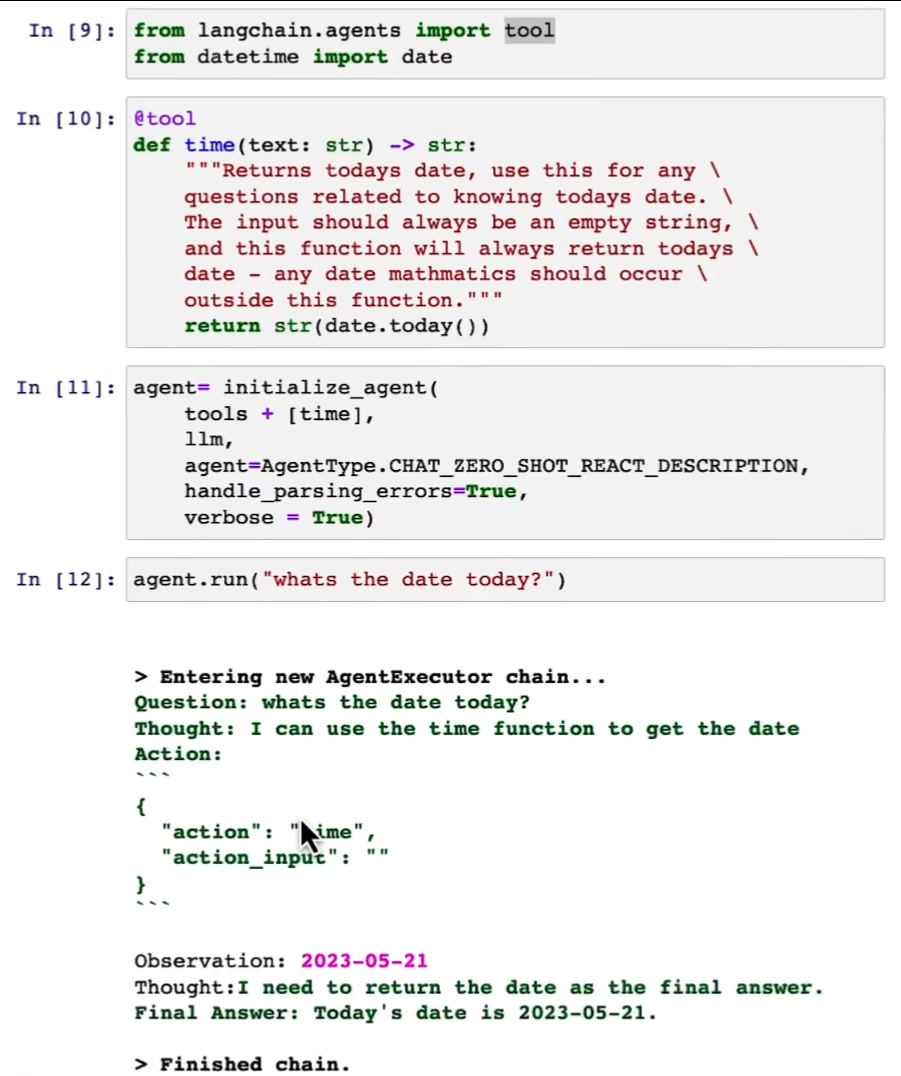

#### 1. 检测没有其他元素+是否valid的tool

In [444]:
from rdkit import Chem
from langchain.agents import tool

@tool
def check_no_extra_element_or_invalid(reactants_reagents_products_smiles: str):
    """This function should be used finally to check answer.
    You need to input a list of SMILES where the SMILES of reactants+reagents and the possible SMILES of products (answer) should be concated using '.'. The molecules are splitted by .\n
    This function will return true or false whether the products contain extra elements out of the reactants and reagents, or whether this products are invalid. \
    If the products contain extra elements, or products are invalid SMILES, return false, otherwise return true. True means the products are invalid and need to regenerate other products. \
    Overall, for the return value of this function, false is good, true is bad. \
    Use this function to check before output the final result.\n

    For example , if you predict the possible product of reactants+regents C/C=C/C=O.Nc1ccc are CC,
    you need to input C/C=C/C=O.Nc1ccc.CC to this function, to check whether CC is a valid answer to the reactants+regents C/C=C/C=O.Nc1ccc. If the return value is false, good; if the return value is true, bad.
    """
    
    if "." not in reactants_reagents_products_smiles:
        return "Invalid input. You need to input a list of SMILES in the format SMILE of reactants+reagents.SMILE of products concated using '.'. The molecules are splitted by ."
    # Split the input strings to obtain lists of reactants, reagents, and products
    reactants_reagents = reactants_reagents_products_smiles.split(".")[:-1]
    products = reactants_reagents_products_smiles.split(".")[-1]

    # Create sets to store the unique elements in reactants and products
    reactants_elements = set()
    products_elements = set()

    # Process each reactant/reagent and add its elements to the set
    for r in reactants_reagents:
        try:
            mol = Chem.MolFromSmiles(r)
            if mol:
                elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
                reactants_elements.update(elements)
        except:
            return True

    # Process each product and add its elements to the set
    for p in products:
        mol = Chem.MolFromSmiles(p)
        if mol:
            elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
            products_elements.update(elements)

    # Check if there are any elements in products that are not in reactants/reagents
    extra_elements = products_elements.difference(reactants_elements)

    # Return True if there are extra elements, otherwise return False
    return bool(extra_elements)



#### 2. 检测原子数量不多于反应物+催化剂的tool 【todo】

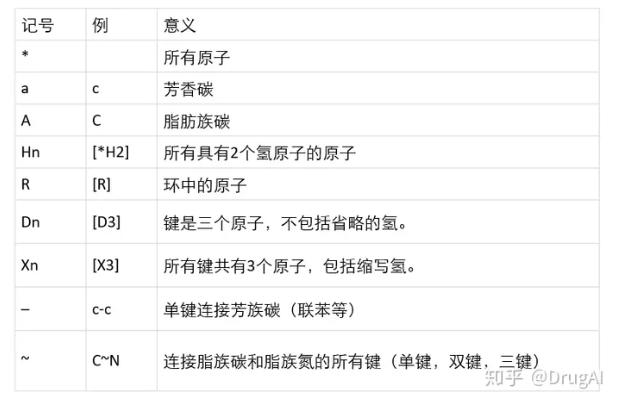

#### 3. 返回反应物的特性的tool

In [461]:
get_molecule_properties("CC(C(=O)O)c1ccc(CBr)cc1")

'Molecule with SMILES: CC(C(=O)O)c1ccc(CBr)cc1\nMolecular Weight: 243.10\nMolecular Formula: C10H11BrO2\nNumber of H-Bond Donors: 1\nNumber of H-Bond Acceptors: 2\nInChI Key: QQXBRVQJMKBAOZ-UHFFFAOYSA-N\nInChI: InChI=1S/C10H11BrO2/c1-7(10(12)13)9-4-2-8(6-11)3-5-9/h2-5,7H,6H2,1H3,(H,12,13)\n'

In [397]:
import requests
import xml.etree.ElementTree as ET

@tool
def get_molecule_properties(smiles: str) -> str:
    """
    Input a smiles for a single molecule, not a list of molecules which concate different molecules with '.' or any other separator. 
    the molecules of reactants and reagents are splitted by '.'. If raise an error stating invalid smile, try to separate input by spliting with '.'.\
    for example, input: CC(C)(C)OC(=O)NC1CCNCC1.O=C(NCCBr)OCc1ccccc1 is not valid, you should input either CC(C)(C)OC(=O)NC1CCNCC1 or O=C(NCCBr)OCc1ccccc1, because these are two different molecules. \
    This function return a text description of the molecule properties.
    The properties contain the molecular weight, molecular formula, number of H-bond donors, number of H-bond acceptors, InChI Key, and InChI.

    The input smiles molecule should be a valid smile in chemistry, otherwise, return an error message. \n

     In the task of SMILES prediction of chemical reactants, we can use the molecular properties and identification information to guide the model in generating accurate SMILES representations. \
number of H-bond donors (H-bond donors) and number of H-bond acceptors: Hydrogen bonding is an important mode of interaction between molecules. \
Hydrogen bond donors are groups that can provide hydrogen atoms, while hydrogen bond acceptors are groups that can accept hydrogen bonds. When predicting reactants, pay attention to the possible hydrogen bond donor and acceptor groups in the molecule, especially at locations in the reaction where hydrogen bonding interactions are likely to occur.
InChI representation can capture stereochemical information, indicating how atoms are arranged in three-dimensional space. Take advantage of this valuable data to predict the correct spatial arrangement of reactant molecules.
    """

    try:
        Chem.MolFromSmiles(smiles)
    except:
        return "Error: Invalid SMILES."


    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,InChIKey,InChI/XML"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            # Parse the XML response with namespaces
            root = ET.fromstring(response.content)
            namespace = {"ns": "http://pubchem.ncbi.nlm.nih.gov/pug_rest"}

            # Extract properties from the XML
            properties = {}
            properties["MolecularWeight"] = root.find(".//ns:MolecularWeight", namespaces=namespace).text
            properties["MolecularFormula"] = root.find(".//ns:MolecularFormula", namespaces=namespace).text
            properties["HBondDonorCount"] = root.find(".//ns:HBondDonorCount", namespaces=namespace).text
            properties["HBondAcceptorCount"] = root.find(".//ns:HBondAcceptorCount", namespaces=namespace).text
            properties["InChIKey"] = root.find(".//ns:InChIKey", namespaces=namespace).text
            properties["InChI"] = root.find(".//ns:InChI", namespaces=namespace).text

            # Create a clean text description
            description = f"Molecule with SMILES: {smiles}\n"
            description += f"Molecular Weight: {properties['MolecularWeight']}\n"
            description += f"Molecular Formula: {properties['MolecularFormula']}\n"
            description += f"Number of H-Bond Donors: {properties['HBondDonorCount']}\n"
            description += f"Number of H-Bond Acceptors: {properties['HBondAcceptorCount']}\n"
            description += f"InChI Key: {properties['InChIKey']}\n"
            description += f"InChI: {properties['InChI']}\n"

            return description
        else:
            return "Error: Unable to fetch molecule properties."
    except Exception as e:
        return f"Error: {e}"

# Example usage:
smiles = "CC"
description = get_molecule_properties(smiles)
print(description)


Molecule with SMILES: CC
Molecular Weight: 30.07
Molecular Formula: C2H6
Number of H-Bond Donors: 0
Number of H-Bond Acceptors: 0
InChI Key: OTMSDBZUPAUEDD-UHFFFAOYSA-N
InChI: InChI=1S/C2H6/c1-2/h1-2H3



#### 4. 引导区分催化剂的tool 【todo】

In [ ]:
@tool
def separate_reagents_from_reactants() -> str:
    """
    
    """

#### 5. 引导思考反应类型的tool 【todo】

In [ ]:
@tool
def think_reaction_type() -> str:
    """
    
    """

#### 6. 基于本地USPTO数据的retrieval

In [212]:
import pandas as pd

uspto_50k_dataset = pd.read_csv('data/uspto_50k.csv')
uspto_50k_dataset

reactants_smiles  \
0      CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(...   
1          COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1   
2      CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C.FC(F)(F)c...   
3        CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1   
4                         Fc1cc2c(Cl)ncnc2cn1.NC1CCCCCC1   
...                                                  ...   
50032             Cc1cc([N+](=O)[O-])ccc1O.Nc1cc(Cl)ccn1   
50033  COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)OC(C)(C)C)CC3   
50034  COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(=...   
50035               C=C(C)Cn1nc(C)c(Br)c1-c1ccc(F)cc1.OO   
50036  COC(=O)c1cc(Br)c(F)c(F)c1Nc1ccccc1F.COc1ccc(CS...   

                                         products_smiles  \
0      O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)...   
1           Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1   
2         CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C   
3                 CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O   
4                            Fc1cc2c(NC3CCCCCC3)ncnc2cn1   
...                                                  ...   
50032                Cc1cc([N+](=O)[O-])ccc1Oc1ccnc(N)c1   
50033          COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)O)CC3   
50034  COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(O...   
50035                  Cc1nn(CC(C)CO)c(-c2ccc(F)cc2)c1Br   
50036    COC(=O)c1cc(SCc2ccc(OC)cc2)c(F)c(F)c1Nc1ccccc1F   

                                         Reagents_smiles  \
0      Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)...   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                             NC1CCCCCC1   
...                                                  ...   
50032                           Cc1cc([N+](=O)[O-])ccc1O   
50033                                                NaN   
50034                                                NaN   
50035                                                NaN   
50036                                     COc1ccc(CS)cc1   

                                   reactants_smiles_only  \
0                            CS(=O)(=O)OC[C@H]1CCC(=O)O1   
1          COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1   
2      CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C.FC(F)(F)c...   
3        CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1   
4                                    Fc1cc2c(Cl)ncnc2cn1   
...                                                  ...   
50032                                      Nc1cc(Cl)ccn1   
50033  COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)OC(C)(C)C)CC3   
50034  COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(=...   
50035               C=C(C)Cn1nc(C)c(Br)c1-c1ccc(F)cc1.OO   
50036                COC(=O)c1cc(Br)c(F)c(F)c1Nc1ccccc1F   

                             reaction_type  
0      heteroatom alkylation and arylation  
1                            deprotections  
2         functional group interconversion  
3                            deprotections  
4      heteroatom alkylation and arylation  
...                                    ...  
50032  heteroatom alkylation and arylation  
50033                        deprotections  
50034                           reductions  
50035      functional group addition (FGA)  
50036  heteroatom alkylation and arylation  

[50037 rows x 5 columns]

In [265]:
df_5reaction= pd.read_csv('data/5reaction.csv')

In [218]:
# 用embedding，embed uspto_50k_dateset的reactants_smiles列。新建一列名为reactants_smiles_embedding
uspto_50k_dataset['reactants_smiles_embedding'] = uspto_50k_dataset['reactants_smiles'].apply(lambda x: GPT4AllEmbeddings().embed_query(x))


Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4a

In [266]:
# 用embedding，embed uspto_50k_dateset的reactants_smiles列。新建一列名为reactants_smiles_embedding
df_5reaction['reactants_smiles_embedding'] = df_5reaction['reactants_smiles'].apply(lambda x: GPT4AllEmbeddings().embed_query(x))


Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin
Found model file at  C:\\\\Users\\\\22100\\\\.cache\\\\gpt4a

In [267]:
df_5reaction.to_csv('data/5reaction_embeded.csv')

In [221]:
uspto_50k_dataset.to_csv('data/uspto_50k_embeded.csv')

In [420]:
import numpy as np
import pandas as pd
import numba as nb

import json
def dataframe_to_json(df):
    # 使用to_dict方法将DataFrame转换成字典
    data_dict = df.to_dict(orient='records')
    
    # 使用json.dumps将字典转换成JSON格式的字符串
    json_str = json.dumps(data_dict, indent=4, ensure_ascii=False)
    
    # 构建输出字符串
    output_str = f"DataFrame information：\n{json_str}"
    
    return output_str

# 使用Numba进行向量化计算，以加快欧氏距离计算的速度
@nb.jit(nopython=True)
def euclidean_distance_numba(vector1, vector2):
    dist = 0.0
    for i in range(len(vector1)):
        dist += (vector1[i] - vector2[i]) ** 2
    return np.sqrt(dist)

def find_nearest_row_index(input_vector, dataframe, k = 3):
    # 将dataframe中的列表转换为NumPy数组，以便进行矩阵运算
    df_arrays = np.array(dataframe['reactants_smiles_embedding'].tolist())

    # 使用Numba加速计算
    distances = np.apply_along_axis(euclidean_distance_numba, 1, df_arrays, input_vector)

    # 找到最小距离对应的行标
    nearest_row_indices = np.argsort(distances)[:k]

    return nearest_row_indices


@tool
def uspto_50k_dataset_search(smiles_of_reactants_reagents: str) -> str:
    """
    You can input a SMILES representation of a reactant+reagents as a whole, which can be a string of multiple molecules connected by '.'. \
    for examples, if your quesition is what the products of the reaction of COc1cc2nc[nH]c(=O)c2cc1OC.ClCCCI, you can input COc1cc2nc[nH]c(=O)c2cc1OC.ClCCCI (exactly the same to the question) to this function. \
    Use this function to search similar reaction with the question. This function will return a json file with 3 similar reactions with their reactants and products, each are independent. \
    This function will utilize a local database to provide you with information about chemical reactions that have similar reactant+catalyst combinations, including the products SMILES, reaction types, which molecules are reagents (separated from SMILES of reactant+reagents). \
    After using this function you get examples of reaction, you may need to use your own knowledge to generate possible reaction steps of these examples. Study these examples and use your own knowledge to predict the products of the question. \
    You can focus on the difference between reactants and products in each reaction (each example), and try to find a law with logical thinking and chemistry knowledge. \
    """

    data = uspto_50k_dataset
    target_vector = GPT4AllEmbeddings().embed_query(smiles_of_reactants_reagents)
    row_indices = find_nearest_row_index(target_vector, data) # data.sample(20000)
    return dataframe_to_json(data.iloc[row_indices][["reactants_smiles","products_smiles"]])
    
    


In [405]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm

# "Scaffold fingerprint"（脚手架指纹）是一种用于描述化学分子结构的编码表示方法。它用于比较和分类化合物，通常用于虚拟筛选、药物设计和化学库分析等领域
# 脚手架指纹是通过将化合物的结构转化为一系列二进制位（或比特位）的向量来表示的。
# 这些二进制位通常编码了分子中的特定化学性质、功能基团或子结构。通过对这些位进行比较，可以量化和比较不同分子之间的相似性。
def get_scaffold_fp(x):
    mol = Chem.MolFromSmiles(x)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold_fp = rdMolDescriptors.GetMorganFingerprint(scaffold, 2)
    return scaffold_fp

uspto_50k_dataset['scaffold_fp'] = uspto_50k_dataset['reactants_smiles'].apply(lambda x: get_scaffold_fp(x))

In [ ]:
# 获取与目标分子(SMILES格式)具有相似骨架(scaffold fingerprint)的前n个分子(SMILES格式), 以及在数据集中的id
def top_n_scaffold_similar_molecules(target_smiles, molecule_scaffold_list, molecule_smiles_list, n=5):
    # 将目标分子的SMILES字符串转换为RDKit的分子对象
    target_mol = Chem.MolFromSmiles(target_smiles)

    # 生成目标分子的Murcko Scaffold骨架
    target_scaffold = MurckoScaffold.GetScaffoldForMol(target_mol)
    
    # 使用Morgan指纹计算目标骨架的指纹fingerprint
    target_fp = rdMolDescriptors.GetMorganFingerprint(target_scaffold, 2)

    # 存储相似性结果的列表
    similarities = []

    # 遍历分子骨架列表
    for idx, scaffold_fp in enumerate(molecule_scaffold_list):
        try:
            tanimoto_similarity = DataStructs.TanimotoSimilarity(target_fp, scaffold_fp) # 计算目标骨架指纹与当前分子骨架指纹的Tanimoto相似度
            if target_fp!=scaffold_fp:
                similarities.append((idx, tanimoto_similarity))  # 将相似度结果添加到相似性列表中
        except Exception as e:
            print(e)
            continue

    similarities.sort(key=lambda x: x[1], reverse=True) # 根据相似度进行排序（从高到低）
    top_5_similar_molecules = similarities[:n] # 获取前n个最相似的分子

    return [molecule_smiles_list[i[0]] for i in top_5_similar_molecules], [i[0] for i in top_5_similar_molecules]

@tool
def uspto_50k_dataset_scaffold_search(smiles_of_reactants_reagents: str) -> str:
    similes, indecies = top_n_scaffold_similar_molecules(smiles_of_reactants_reagents, list(uspto_50k_dataset['scaffold_fp']), list(uspto_50k_dataset['reactants_smiles']), n=5)
    return dataframe_to_json(uspto_50k_dataset.iloc[indecies][["reactants_smiles","products_smiles","reaction_type"]])

# Retrieval-QA (URL/HTLM/Doc BASED)

In [10]:
!pip install openai
!pip install chromadb


     -------------------------------------- 399.3/399.3 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 58.4/58.4 kB ? eta 0:00:00
     ---------------------------------------- 59.5/59.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 6.7/6.7 MB 11.0 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 12.3 MB/s eta 0:00:00
     ---------------------------------------- 67.3/67.3 kB ? eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to

  error: subprocess-exited-with-error
  
  × Building wheel for chroma-hnswlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [5 lines of output]
      running bdist_wheel
      running build
      running build_ext
      building 'hnswlib' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for chroma-hnswlib
ERROR: Could not build wheels for chroma-hnswlib, which is required to install pyproject.toml-based projects


In [15]:
pip install chromadb

  Using cached chromadb-0.4.2-py3-none-any.whl (399 kB)
  Using cached chroma-hnswlib-0.7.1.tar.gz (30 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached fastapi-0.99.1-py3-none-any.whl (58 kB)
  Using cached uvicorn-0.23.1-py3-none-any.whl (59 kB)
  Using cached posthog-3.0.1-py2.py3-none-any.whl (37 kB)
  Using cached pulsar_client-3.2.0-cp39-cp39-win_amd64.whl (3.4 MB)
  Using cached onnxruntime-1.15.1-cp39-cp39-win_amd64.whl (6.7 MB)
  Using cached tokenizers-0.13.3-cp39-cp39-win_amd64.whl (3.5 MB)
  Using cached PyPika-0.48.9-py2.py3-none-any.whl
  Using cached overrides-7.3.1-py3-none-any.whl (17 kB)
  Using cached starlette-0.27.0-py3-none-any.whl (66 kB)
  Using cached coloredlogs-15.0

In [11]:
# 引入库
import openai
import os
from langchain.llms import OpenAI
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from dotenv import load_dotenv
load_dotenv()
 
# 载入 API keys; 如果没有，你需要先获取。 
os.environ["OPENAI_API_KEY"] = "OEPN_AI_API"
os.environ["SERPER_API_KEY"] = "aa8785a775f630cc3e542817a6e6d6757bb9fcea"

In [16]:
from langchain.document_loaders import WebBaseLoader
from langchain.indexes import VectorstoreIndexCreator

# Document loader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
# Index that wraps above steps
index = VectorstoreIndexCreator().from_loaders([loader])
# Question-answering
question = "What is Task Decomposition?"
index.query(question)

' Task decomposition is a technique used to break down complex tasks into smaller and simpler steps. It can be done using LLM with simple prompting, task-specific instructions, or human inputs. Tree of Thoughts (Yao et al. 2023) is an example of a task decomposition technique that explores multiple reasoning possibilities at each step and generates a tree structure.'

In [17]:
pip install unstructured

     ---------------------------------------- 1.4/1.4 MB 4.5 MB/s eta 0:00:00
     ------------------------------------- 199.1/199.1 kB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 3.9/3.9 MB 10.8 MB/s eta 0:00:00
     -------------------------------------- 101.8/101.8 kB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 13.8 MB/s eta 0:00:00
     -------------------------------------- 250.0/250.0 kB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 13.8 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 10.1/10.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 93.9/93.9 kB 5.2 MB/s eta 0:00:00
  

## test

In [75]:
from langchain.document_loaders import UnstructuredURLLoader
from langchain.document_loaders import WebBaseLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# Loader (2 loaders)
loader = WebBaseLoader("https://pubchem.ncbi.nlm.nih.gov/compound/240")
# loader = UnstructuredURLLoader(urls=["https://pubchem.ncbi.nlm.nih.gov/compound/240"],
#                                 mode="elements", strategy="fast")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)

# Store
vectorstore = Chroma.from_documents(documents=all_splits,embedding=OpenAIEmbeddings())

# Build prompt
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# question setting ---
question = "What is the molecular Formula of Benzaldehyde?"

# Run chain
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
qa_chain = RetrievalQA.from_chain_type(llm,
                    retriever=vectorstore.as_retriever(),
                    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

result = qa_chain({"query": question})
result["result"]

'The molecular formula of Benzaldehyde is C6H5CHO.'

In [76]:
data

[Document(page_content='\n\n\n\n\nBenzaldehyde | C6H5CHO | CID 240 - PubChem\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJavaScript is required...\nPlease enable Javascript in order to use PubChem website.\n\n\n\n\n\n\n\n\n\n\n\n\n', metadata={'source': 'https://pubchem.ncbi.nlm.nih.gov/compound/240', 'title': 'Benzaldehyde | C6H5CHO | CID 240 - PubChem', 'description': 'Benzaldehyde | C6H5CHO or C7H6O | CID 240 - structure, chemical names, physical and chemical properties, classification, patents, literature, biological activities, safety/hazards/toxicity information, supplier lists, and more.', 'language': 'en'})]

## Retrieval from pubchem web page

In [13]:
pip install pubchempy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13839 sha256=a5a1738c92bc47196de6a9d0a6369fa683ace9ab220e2e5a0c236e2bc8a0e509
  Stored in directory: c:\users\22100\appdata\local\pip\cache\wheels\84\45\0e\b597debba098119b642eaf728ae1883d23ad8ea2a9366f2ded
Successfully built pubchempy
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pubchempy as pcp

def get_cid_from_smiles(smiles):
    try:
        compound = pcp.get_compounds(smiles, 'smiles')
        if compound:
            return compound[0].cid
        else:
            print("No compound found for the given SMILES.")
            return None
    except pcp.PubChemHTTPError as e:
        print(f"Error: {e}")
        return None

# 示例用法
smiles_input = "CC(=O)OC1=CC=CC=C1C(=O)O"  # 将你的SMILES输入在这里
cid = get_cid_from_smiles(smiles_input)
if cid:
    print(f"The CID for the input SMILES '{smiles_input}' is: {cid}")


The CID for the input SMILES 'CC(=O)OC1=CC=CC=C1C(=O)O' is: 2244


In [82]:
from langchain.document_loaders import UnstructuredURLLoader
from langchain.document_loaders import WebBaseLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

def Retrieval_QA_chat(smiles, question):
    # get cid
    cids = []
    for s in smiles.split('.'):
        cid = get_cid_from_smiles(s)
        if cid:
            cids.append(cid)

    # Load
    loader = WebBaseLoader([f"https://pubchem.ncbi.nlm.nih.gov/compound/{cid}" for cid in cids])
    # loader = UnstructuredURLLoader(urls=[f"https://pubchem.ncbi.nlm.nih.gov/compound/{cid}" for cid in cids],
    #                                 mode="elements", strategy="fast")
    data = loader.load()

    # Split
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
    all_splits = text_splitter.split_documents(data)

    # Store
    vectorstore = Chroma.from_documents(documents=all_splits,embedding=OpenAIEmbeddings())

    # Build prompt
    template = """You are an expert chemist. Please predict the reaction type and possible products of a reaction in SMILES format.  Here are some information for you to refer \n{context}, \nQuestion: {question}"""
    QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template)

    # Run chain
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    qa_chain = RetrievalQA.from_chain_type(llm,
                        retriever=vectorstore.as_retriever(),
                        chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

    result = qa_chain({"query": question})
    return result["result"], data




In [83]:
question = """
You are an expert chemist. Please predict the reaction type and possible products of a reaction in SMILES format. Strictly follow the format, no other information can be provided.
The input contains the reactants and reagents which are splitted by . 
The product smiles must be valid and chemically reasonable. 
Reactants+Reagents: CC(C)(C)OC(=O)N1CCCC(N)CC1.O=C(Cl)OCc1ccccc1\n
Products: CC(C)(C)OC(=O)N1CCCC(NC(=O)OCc2ccccc2)CC1\n
Reactants+Reagents: CC(C)(C)OC(=O)N1CCC[C@@H]1CN.O=[N+]([O-])c1ccccc1F\n
Products: CC(C)(C)OC(=O)N1CCC[C@@H]1CNc1ccccc1[N+](=O)[O-]\n
Reactants+Reagents: COC(=O)[C@@H]1[C@@H](O)CCN1C(=O)OC(C)(C)C.O=C(O)c1ccccc1\n
Products: COC(=O)[C@@H]1[C@H](OC(=O)c2ccccc2)CCN1C(=O)OC(C)(C)C\n
Reactants+Reagents: CC(C)OC(=O)c1cc(N=C=S)ccc1Cl.CCOC(=O)[C@@H]1CCCN1\n
Products: CCOC(=O)C1CCCN1C(=S)Nc1ccc(Cl)c(C(=O)OC(C)C)c1\n
Reactants+Reagents: CC(C)NC[C@@H]1CN(C(=O)OC(C)(C)C)C[C@H]1C(C)(C)O[SiH2]C(C)(C)C.CCc1ccc(C(=O)O)cc1OCCCOC\n
Products: CCc1ccc(C(=O)N(C[C@@H]2CN(C(=O)OC(C)(C)C)C[C@H]2C(C)(C)O[SiH2]C(C)(C)C)C(C)C)cc1OCCCOC\n
Reactants+Reagents: CC(C)(C)OC(=O)NC1CCNCC1.O=C(NCCBr)OCc1ccccc1\n
Products:
"""

In [84]:
result, data = Retrieval_QA_chat("CC(C)(C)OC(=O)NC1CCNCC1.O=C(NCCBr)OCc1ccccc1", question)
result

'CC(C)(C)OC(=O)NC1CCNCC1NC(=O)OCc2ccccc2'

In [87]:
data[0]

Document(page_content='\n\n\n\n\nTert-butyl piperidin-4-ylcarbamate | C10H20N2O2 | CID 723833 - PubChem\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJavaScript is required...\nPlease enable Javascript in order to use PubChem website.\n\n\n\n\n\n\n\n\n\n\n\n\n', metadata={'source': 'https://pubchem.ncbi.nlm.nih.gov/compound/723833', 'title': 'Tert-butyl piperidin-4-ylcarbamate | C10H20N2O2 | CID 723833 - PubChem', 'description': 'Tert-butyl piperidin-4-ylcarbamate | C10H20N2O2 | CID 723833 - structure, chemical names, physical and chemical properties, classification, patents, literature, biological activities, safety/hazards/toxicity information, supplier lists, and more.', 'language': 'en'})

# API-based Retrieval-QA

https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest-tutorial#section=How-PUG-REST-Works

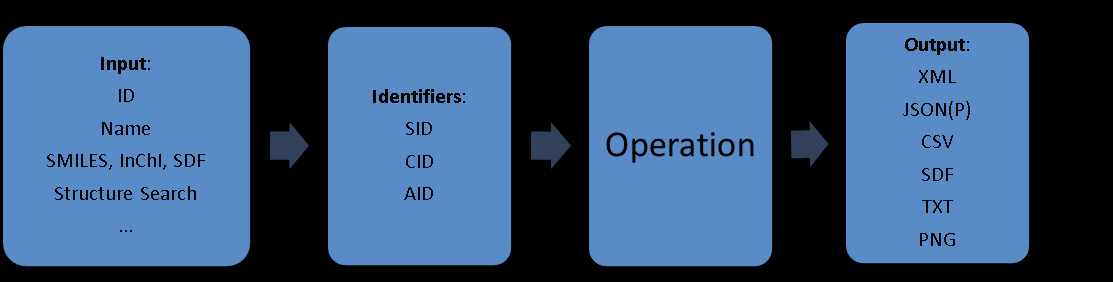

In [1]:
from langchain.document_loaders import UnstructuredXMLLoader

In [2]:
# 写一个从某一网址下载文件存到本地，并返回本地文件路径的函数
import requests
def download_file(url, local_filename):
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename

In [4]:
download_file("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/CCCCBr/record/XML",
              "cache/CCCCBr.xml")

'cache/CCCCBr.xml'

In [7]:
from langchain.document_loaders import UnstructuredXMLLoader
UnstructuredXMLLoader("cache/CCCCBr.xml").load()

[Document(page_content='8002\n\n1\n\n2\n\n3\n\n4\n\n5\n\n6\n\n7\n\n8\n\n9\n\n10\n\n11\n\n12\n\n13\n\n14\n\n35\n\n6\n\n6\n\n6\n\n6\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n2\n\n2\n\n2\n\n2\n\n3\n\n3\n\n3\n\n4\n\n4\n\n5\n\n5\n\n5\n\n4\n\n3\n\n4\n\n6\n\n7\n\n5\n\n8\n\n9\n\n10\n\n11\n\n12\n\n13\n\n14\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n1\n\n5\n\n255\n\n1\n\n2\n\n3\n\n4\n\n5\n\n6\n\n7\n\n8\n\n9\n\n10\n\n11\n\n12\n\n13\n\n14\n\n5.4641\n\n3.732\n\n2.866\n\n4.5981\n\n2\n\n3.3335\n\n4.1306\n\n3.2646\n\n2.4675\n\n4.9966\n\n4.1996\n\n1.69\n\n1.4631\n\n2.31\n\n\n\n0.25\n\n\n\n0.25\n\n0.25\n\n0.25\n\n\n\n0.25\n\n\n\n0.7249\n\n\n\n0.7249\n\n0.7249\n\n0.7249\n\n0.7249\n\n0.7249\n\n0.2869\n\n\n\n0.56\n\n\n\n0.7869\n\n0\n\nCompound\n\nCanonicalized\n\n5\n\n2021.05.07\n\n1\n\nCompound Complexity\n\n7\n\nE_COMPLEXITY\n\n3.4.8.18\n\nCactvs\n\nXemistry GmbH\n\n2021.05.07\n\n13.1\n\nCount\n\nHydrogen Bond Acceptor\n\n5\n\nE_NHACCEPTORS\n\n3.4.8.18\n\nCactvs\n\nXem

---

experiment 3.1 使用pubchem的api + naive retrieval

In [103]:
from langchain.document_loaders import UnstructuredURLLoader
from langchain.document_loaders import WebBaseLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

def Retrieval_QA_apibased(smiles, question, property_flag = False):
    data_list = []
    for s in smiles.split('.'):
        if property_flag==False:
          download_file(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{s}/record/XML",
                f"cache/{s}.xml")
        else:
          download_file(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{s}/property/MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,InChIKey,InChI/XML",
                        f"cache/property/{s}.xml")

        if property_flag==False:
          loader = UnstructuredXMLLoader(f"cache/{s}.xml", xml_keep_tags=True)
        else:
          loader = UnstructuredXMLLoader(f"cache/property/{s}.xml", xml_keep_tags=True)
          
        data = loader.load()
        for d in data:
            data_list.append(d)

    # Split
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
    all_splits = text_splitter.split_documents(data_list)

    # Store
    vectorstore = Chroma.from_documents(documents=all_splits,embedding=OpenAIEmbeddings())

    # Build prompt
    template = """You are an expert chemist. Please predict the possible products of a reaction in SMILES format. Use the chemical properties of reactants and reagents to predict the possible products of this reaction. \
      Here are some chemical properties of reactants and reagents for you to refer \n{context}. \
        Please consider the HBondDonorCount, HBondAcceptorCount, Molecular Weight, MolecularFormula, InChIKey, InChI of reactants and reagents for the final products prediction.
        \nQuestion: {question}"""
    QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template)

    # llm
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

    # chain
    qa_chain = RetrievalQA.from_chain_type(llm,
                        retriever=vectorstore.as_retriever(),
                        chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
                        verbose=True,
                        chain_type = "stuff") # map_reduce/stuff/refine/map_rerank

    result = qa_chain({"query": question})
    return result["result"], data_list




In [104]:
question = """
You are an expert chemist. Please predict the possible products of a reaction in SMILES format, given reactants and reagents. Strictly follow the format, you should only output the products based on the examples. \n
Please consider the HBondDonorCount, HBondAcceptorCount, Molecular Weight, MolecularFormula, InChIKey, InChI of reactants and reagents for the final products prediction.\n 
 The input contains the reactants and reagents which are splitted by . 
 Products should not be the same as reactants and reagents. If not, output another product in your second thought.
 the product smiles must be valid and chemically reasonable. 
Reactants+Reagents: COC(=O)c1cc2[nH]nc(Br)c2cn1.ClC(c1ccccc1)(c1ccccc1)c1ccccc1\n
Products: 
"""


# Reactants+Reagents: COC(=O)c1cc2[nH]nc(Br)c2cn1.ClC(c1ccccc1)(c1ccccc1)c1ccccc1\n
# Products: COC(=O)c1cc2c(cn1)c(Br)nn2C(c1ccccc1)(c1ccccc1)c1ccccc1\n
# Reactants+Reagents: CCOC(=O)c1cc(B(O)O)ccc1Cl.Cc1cc(Cl)ccc1C(CC(=O)c1ccc(=O)n(C)c1)c1ccc(O)c(F)c1\n
# Products: CCOC(=O)c1cc(Oc2ccc(C(CC(=O)c3ccc(=O)n(C)c3)c3ccc(Cl)cc3C)cc2F)ccc1Cl\n
# Reactants+Reagents: COC(=O)Cn1ncc2cc(-c3cc(C(=O)NC4CC4)ccc3C)ccc21.NCc1ccccc1\n
# Products: Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(cnn2CC(=O)NCc2ccccc2)c1\n
# Reactants+Reagents: CN(C)CCN(C)c1nc2ccc(NC(=O)c3ccc(I)cc3)cc2s1.COc1ccc(B(O)O)cc1\n
# Products: COc1ccc(-c2ccc(C(=O)Nc3ccc4nc(N(C)CCN(C)C)sc4c3)cc2)cc1\n
# Reactants+Reagents: CC(C)(C(=O)Nc1nncs1)C(c1ccccc1)c1ccc2[nH]ncc2c1.Ic1ccccc1.O=P([O-])([O-])[O-].[K+].[K+].[K+]\n

result, data_list = Retrieval_QA_apibased("COC(=O)c1cc2[nH]nc(Br)c2cn1.ClC(c1ccccc1)(c1ccccc1)c1ccccc1", question, property_flag = True)



> Entering new RetrievalQA chain...

> Finished chain.


In [105]:
result

'COC(=O)c1cc2[nH]nc(Br)c2cn1.ClC(c1ccccc1)(c1ccccc1)c1ccccc1.[O-]P(=O)([O-])[O-]'